<a href="https://colab.research.google.com/github/mmtaha/Ciencia-de-dados---Projeto-Detectando_Fraudes_em_Transferncias/blob/main/ciencia_de_dados_detectando_fraudes_em_transferncias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencia De Dados - Detectando Fraudes Em Transferências Bancárias

## Qual o Problema de Negócio

Esse conjunto de dados fictício possui transações de transferências entre contas de uma mesma Instituição Financeira. São mais de 200 mil registros de transferências, sendo 490 Fraudulentas, ou seja, não foram realizadas pelo dono da conta corrente. Temos 28 variáveis explicativas e a variável Classe é o Target e assume o valor 1 em caso de fraude e 0 em caso contrário.

In [88]:
!pip install matplotlib xgboost lightgbm kaggle seaborn numpy kagglehub scipy

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Carregando o dataset
file_path = "transferencias.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "kelvimimperial/deteco-de-fraudes-em-cartes-de-credito",
    file_path,
)

print(f"Dimensões do dataset: {df.shape[0]} linhas × {df.shape[1]} colunas")

Using Colab cache for faster access to the 'deteco-de-fraudes-em-cartes-de-credito' dataset.
Dimensões do dataset: 284807 linhas × 31 colunas


#ANÁLISE EXPLORATÓRIA VISUAL

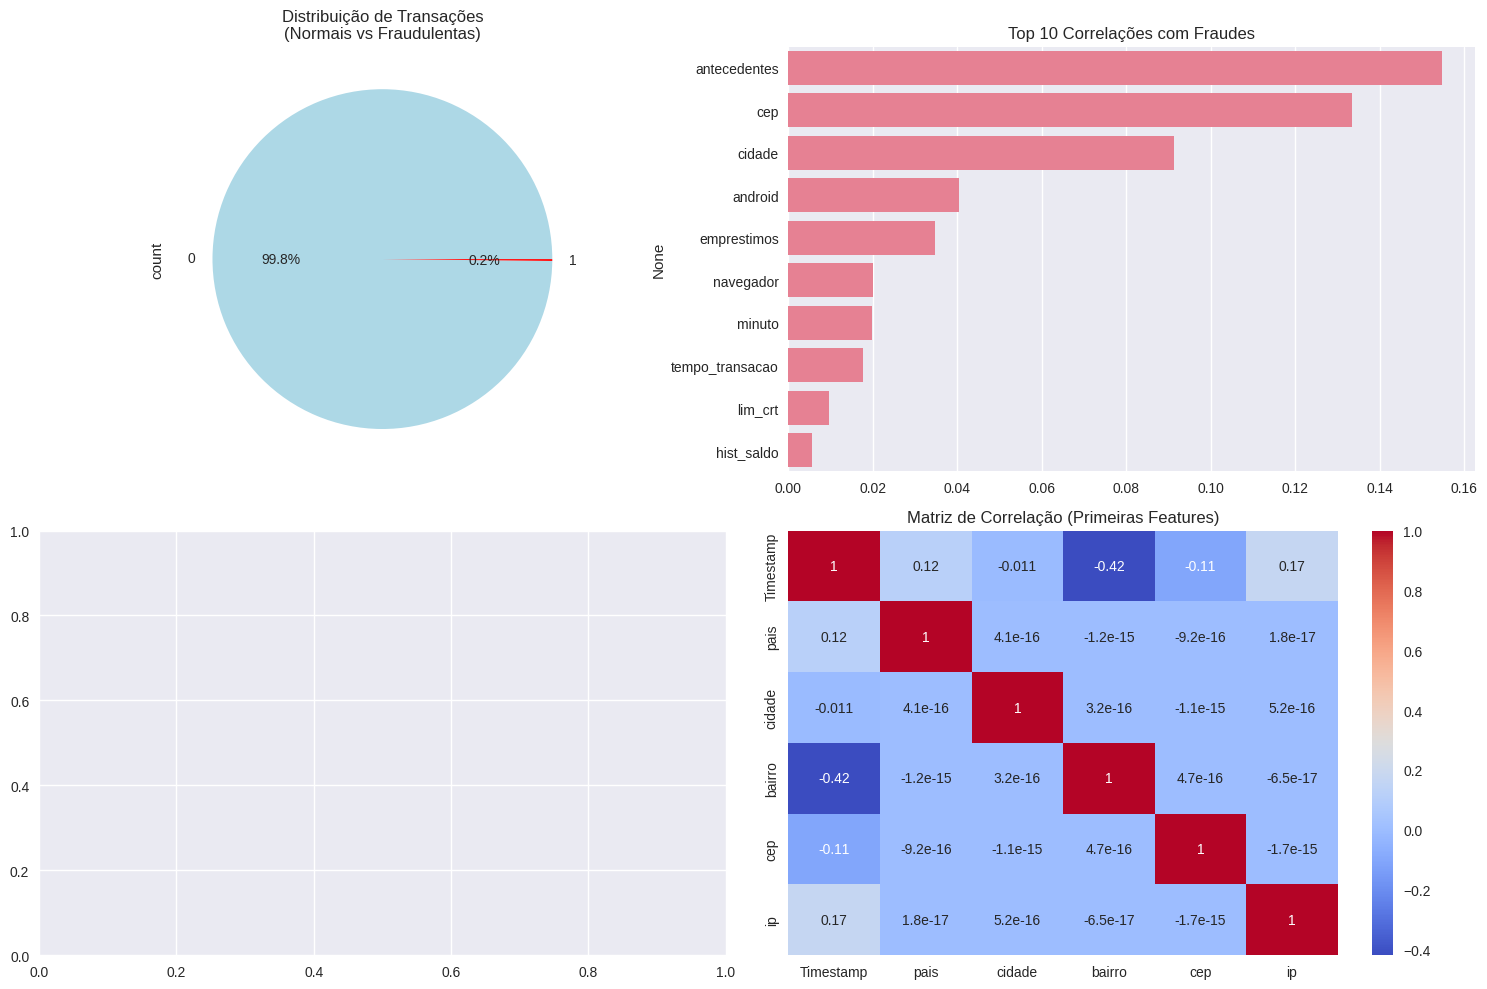

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Distribuição do target
df['Target'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0,0], colors=['lightblue', 'red'])
axes[0,0].set_title('Distribuição de Transações\n(Normais vs Fraudulentas)')

# Gráfico 2: Correlações com o target
correlations = df.corr()['Target'].sort_values(ascending=False).drop('Target')
top_correlations = correlations.head(10)
sns.barplot(x=top_correlations.values, y=top_correlations.index, ax=axes[0,1])
axes[0,1].set_title('Top 10 Correlações com Fraudes')

# Gráfico 3: Distribuição de algumas features (exemplo)
if 'V1' in df.columns:
    sns.boxplot(data=df, x='Target', y='V1', ax=axes[1,0])
    axes[1,0].set_title('Distribuição da Feature V1 por Tipo de Transação')

# Gráfico 4: Matriz de correlação (apenas primeiras features)
if len(df.columns) > 5:
    sns.heatmap(df.iloc[:, :6].corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
    axes[1,1].set_title('Matriz de Correlação (Primeiras Features)')

plt.tight_layout()
plt.show()

# Análise da variável target

In [50]:
print(f"\n Distribuição da Variável Target:")
target_dist = df['Target'].value_counts()
print(f"• Transações Normais (0): {target_dist[0]:,} ({target_dist[0]/len(df)*100:.2f}%)")
print(f"• Transações Fraudulentas (1): {target_dist[1]:,} ({target_dist[1]/len(df)*100:.2f}%)")



 Distribuição da Variável Target:
• Transações Normais (0): 284,315 (99.83%)
• Transações Fraudulentas (1): 492 (0.17%)


# PRÉ-PROCESSAMENTO E BALANCEAMENTO

In [51]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Separar features e target
X = df.drop('Target', axis=1)
y = df['Target']

print(f"Antes do balanceamento:")
print(f"• Classe 0 (Normal): {(y == 0).sum()} amostras")
print(f"• Classe 1 (Fraude): {(y == 1).sum()} amostras")

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"Após balanceamento com SMOTE:")
print(f"• Classe 0 (Normal): {(y_balanced == 0).sum()} amostras")
print(f"• Classe 1 (Fraude): {(y_balanced == 1).sum()} amostras")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"\nDivisão dos dados:")
print(f"• Conjunto de treino: {X_train.shape[0]} amostras")
print(f"• Conjunto de teste: {X_test.shape[0]} amostras")

Antes do balanceamento:
• Classe 0 (Normal): 284315 amostras
• Classe 1 (Fraude): 492 amostras
Após balanceamento com SMOTE:
• Classe 0 (Normal): 284315 amostras
• Classe 1 (Fraude): 284315 amostras

Divisão dos dados:
• Conjunto de treino: 398041 amostras
• Conjunto de teste: 170589 amostras


#Análise de Correlação Avançada


 Análise de Correlação com a Variável Target:

Top 10 correlações positivas:
Target             1.000000
antecedentes       0.154876
cep                0.133447
cidade             0.091289
android            0.040413
emprestimos        0.034783
navegador          0.020090
minuto             0.019875
tempo_transacao    0.017580
lim_crt            0.009536
Name: Target, dtype: float64

Top 10 correlações negativas:
so                -0.097733
pais              -0.101347
contas            -0.111485
hora              -0.187257
bairro            -0.192961
tipo_crt          -0.196539
valor             -0.216883
reclamacoes       -0.260593
crt               -0.302544
estabelecimento   -0.326481
Name: Target, dtype: float64


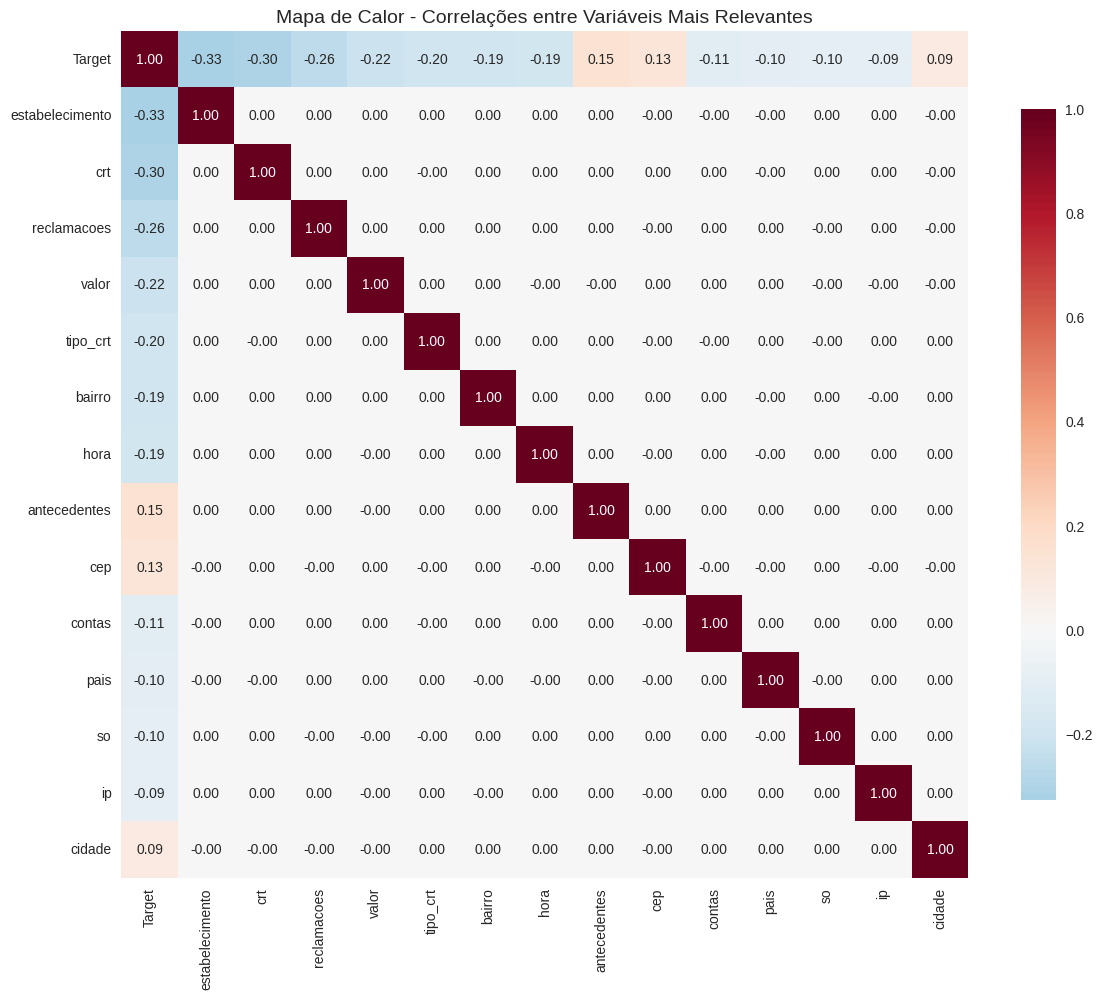

In [52]:
print("\n Análise de Correlação com a Variável Target:")
correlations = df.corr()['Target'].sort_values(ascending=False)
print("\nTop 10 correlações positivas:")
print(correlations.head(10))
print("\nTop 10 correlações negativas:")
print(correlations.tail(10))

top_features = correlations.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Mapa de Calor - Correlações entre Variáveis Mais Relevantes', fontsize=14)
plt.tight_layout()
plt.show()


#Análise de Outliers

In [53]:
print("\n Análise de Outliers nas Variáveis Numéricas:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_analysis = []

for col in numeric_cols:
    if col != 'Target':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percent = (len(outliers) / len(df)) * 100
        outlier_analysis.append({
            'Variável': col,
            'Outliers': len(outliers),
            'Percentual': f"{outlier_percent:.2f}%"
        })

outlier_df = pd.DataFrame(outlier_analysis).sort_values('Outliers', ascending=False)
print(outlier_df.head(10))



 Análise de Outliers nas Variáveis Numéricas:
           Variável  Outliers Percentual
27  tempo_transacao     39163     13.75%
29       hist_saldo     31904     11.20%
28          lim_crt     30342     10.65%
20        navegador     27770      9.75%
8            minuto     24134      8.47%
6               dia     22965      8.06%
23          compras     18541      6.51%
12      reclamacoes     15348      5.39%
21          android     14497      5.09%
14              crt     14149      4.97%


#TREINAMENTO DE MÚLTIPLOS MODELOS



In [44]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Lista de modelos para testar
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

resultados = {}

print("Treinando modelos...")

for nome, modelo in models.items():
    print(f"\n{nome}:")

    # Treinar modelo
    modelo.fit(X_train, y_train)

    # Fazer previsões
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    # Calcular métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = modelo.score(X_test, y_test)

    resultados[nome] = {
        'modelo': modelo,
        'auc': auc,
        'accuracy': accuracy,
        'previsoes': y_pred,
        'probabilidades': y_pred_proba
    }

    print(f"Acurácia: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")

Treinando modelos...

Regressão Logística:
Acurácia: 0.9804
AUC: 0.9973

Random Forest:
Acurácia: 0.9998
AUC: 1.0000

XGBoost:
Acurácia: 0.9998
AUC: 1.0000


# AVALIAÇÃO E COMPARAÇÃO DOS MODELOS


Ranking dos Modelos:
             Modelo  Acurácia      AUC
      Random Forest  0.999830 0.999999
            XGBoost  0.999812 0.999995
Regressão Logística  0.980444 0.997287

Melhor modelo: Random Forest


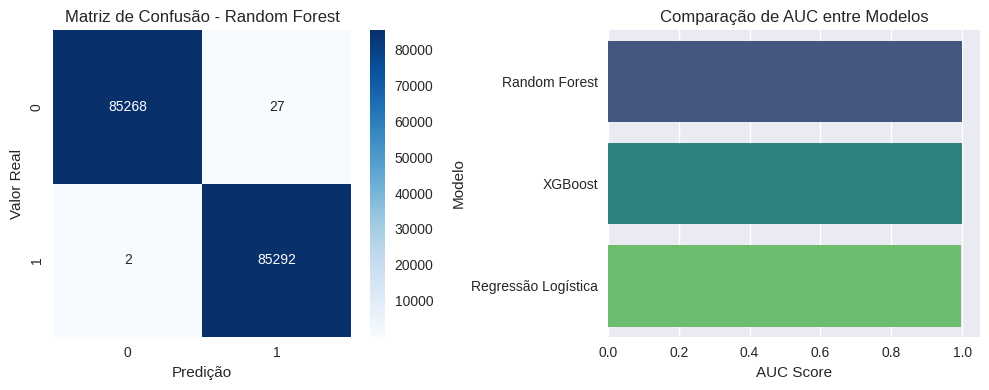


Relatório Detalhado - Random Forest:
                       precision    recall  f1-score   support

     Transação Normal       1.00      1.00      1.00     85295
Transação Fraudulenta       1.00      1.00      1.00     85294

             accuracy                           1.00    170589
            macro avg       1.00      1.00      1.00    170589
         weighted avg       1.00      1.00      1.00    170589



In [45]:
# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acurácia': [resultados[nome]['accuracy'] for nome in resultados.keys()],
    'AUC': [resultados[nome]['auc'] for nome in resultados.keys()]
}).sort_values('AUC', ascending=False)

print("\nRanking dos Modelos:")
print(comparacao.to_string(index=False))

# Identificar melhor modelo
melhor_modelo_nome = comparacao.iloc[0]['Modelo']
melhor_modelo = resultados[melhor_modelo_nome]['modelo']

print(f"\nMelhor modelo: {melhor_modelo_nome}")

# Matriz de confusão do melhor modelo
y_pred_melhor = resultados[melhor_modelo_nome]['previsoes']
cm = confusion_matrix(y_test, y_pred_melhor)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {melhor_modelo_nome}')
plt.ylabel('Valor Real')
plt.xlabel('Predição')

# Gráfico de comparação de modelos
plt.subplot(1, 2, 2)
sns.barplot(data=comparacao, x='AUC', y='Modelo', palette='viridis')
plt.title('Comparação de AUC entre Modelos')
plt.xlabel('AUC Score')

plt.tight_layout()
plt.show()

# Relatório de classificação detalhado
print(f"\nRelatório Detalhado - {melhor_modelo_nome}:")
print(classification_report(y_test, y_pred_melhor,
                          target_names=['Transação Normal', 'Transação Fraudulenta']))


# Divisão estratificada dos dados

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"\n Divisão dos dados:")
print(f"• Treino: {X_train.shape[0]:,} amostras")
print(f"• Teste: {X_test.shape[0]:,} amostras")


 Divisão dos dados:
• Treino: 398,041 amostras
• Teste: 170,589 amostras


# Modelagem Avançada

In [89]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, precision_recall_curve, auc,
                           f1_score, precision_score, recall_score)

# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Avaliação dos modelos
results = {}

print("\nTreinando e avaliando modelos...")

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Treinamento
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Métricas
    accuracy = model.score(X_test, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Acurácia: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")



Treinando e avaliando modelos...

--- Logistic Regression ---
Acurácia: 0.9804
AUC: 0.9973
F1-Score: 0.9802
Precisão: 0.9906
Recall: 0.9701

--- Random Forest ---
Acurácia: 0.9998
AUC: 1.0000
F1-Score: 0.9998
Precisão: 0.9997
Recall: 1.0000

--- XGBoost ---
Acurácia: 0.9998
AUC: 1.0000
F1-Score: 0.9998
Precisão: 0.9996
Recall: 1.0000

--- LightGBM ---
Acurácia: 0.9995
AUC: 0.9999
F1-Score: 0.9995
Precisão: 0.9991
Recall: 1.0000

--- Gradient Boosting ---
Acurácia: 0.9873
AUC: 0.9993
F1-Score: 0.9872
Precisão: 0.9938
Recall: 0.9807



COMPARAÇÃO DOS MODELOS

Ranking dos Modelos (por F1-Score):
             Modelo  Acurácia      AUC  F1-Score  Precisão   Recall
            XGBoost  0.999719 0.999972  0.999684  0.999414 0.999953
      Random Forest  0.999677 0.999966  0.999637  0.999531 0.999742
           LightGBM  0.999541 0.999920  0.999484  0.999133 0.999836
  Gradient Boosting  0.986608 0.999162  0.984809  0.993086 0.976669
Logistic Regression  0.980376 0.997187  0.977694  0.987981 0.967618


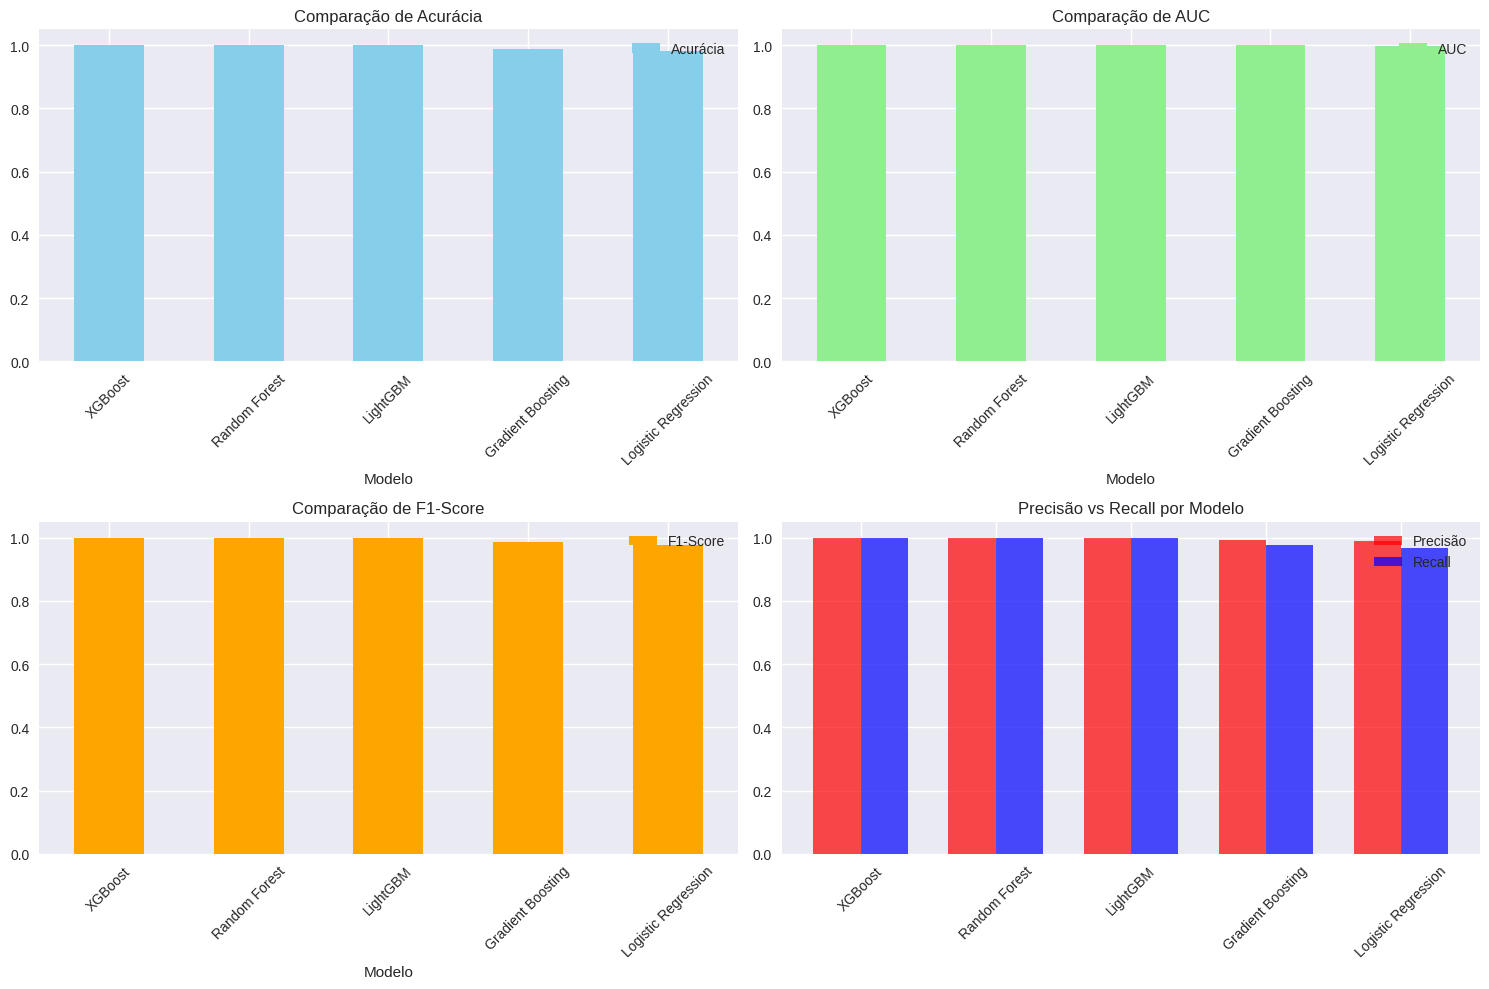

In [46]:
# Garantir que todas as métricas estão calculadas
for name in resultados.keys():
    from sklearn.metrics import f1_score, precision_score, recall_score

    y_pred = resultados[name]['previsoes']
    resultados[name]['f1'] = f1_score(y_test, y_pred)
    resultados[name]['precision'] = precision_score(y_test, y_pred)
    resultados[name]['recall'] = recall_score(y_test, y_pred)

# Criar DataFrame de comparação
results_df = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acurácia': [resultados[name]['accuracy'] for name in resultados.keys()],
    'AUC': [resultados[name]['auc'] for name in resultados.keys()],
    'F1-Score': [resultados[name]['f1'] for name in resultados.keys()],
    'Precisão': [resultados[name]['precision'] for name in resultados.keys()],
    'Recall': [resultados[name]['recall'] for name in resultados.keys()]
}).sort_values('F1-Score', ascending=False)

print("\n🏆 Ranking dos Modelos (por F1-Score):")
print(results_df.to_string(index=False))

# Visualização da comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Acurácia
results_df.plot(x='Modelo', y='Acurácia', kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Comparação de Acurácia')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# AUC
results_df.plot(x='Modelo', y='AUC', kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Comparação de AUC')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# F1-Score
results_df.plot(x='Modelo', y='F1-Score', kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Comparação de F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Precisão vs Recall
x = range(len(results_df))
width = 0.35
axes[1,1].bar([i - width/2 for i in x], results_df['Precisão'], width, label='Precisão', color='red', alpha=0.7)
axes[1,1].bar([i + width/2 for i in x], results_df['Recall'], width, label='Recall', color='blue', alpha=0.7)
axes[1,1].set_title('Precisão vs Recall por Modelo')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(results_df['Modelo'], rotation=45)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Análise Detalhada do Melhor Modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model = resultados[best_model_name]['modelo']
best_predictions = resultados[best_model_name]['previsoes']  # Linha corrigida

#ANÁLISE DAS FEATURES MAIS IMPORTANTES


🔍 Top 10 Features Mais Importantes:
        Feature  Importância
            crt     0.217251
          valor     0.122546
            cep     0.112927
    reclamacoes     0.108611
estabelecimento     0.088295
         bairro     0.071085
   antecedentes     0.051169
       tipo_crt     0.040932
         cidade     0.038399
             so     0.027031


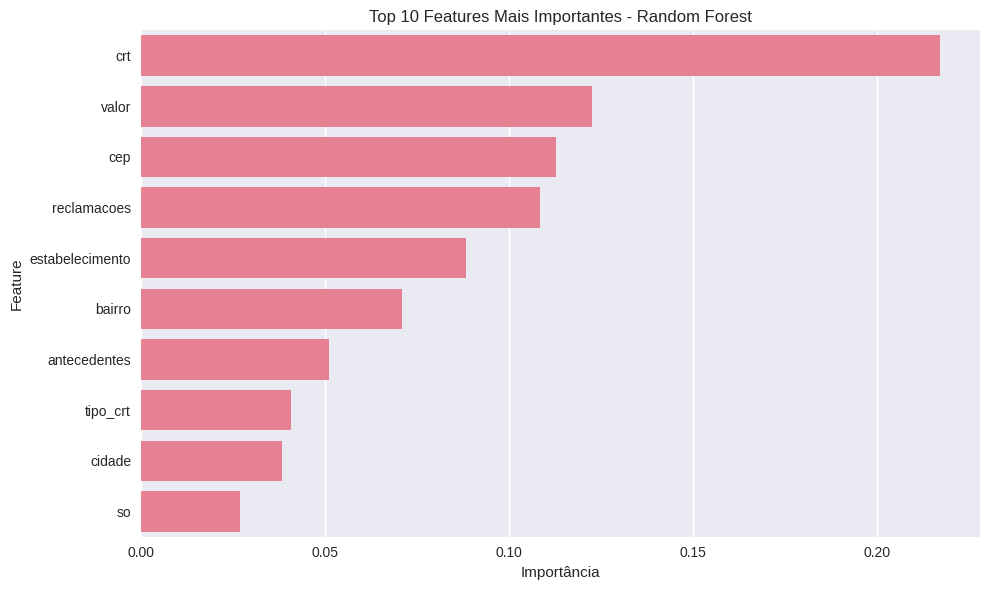

In [47]:
if hasattr(melhor_modelo, 'feature_importances_'):
    # Extrair importância das features
    importancia = pd.DataFrame({
        'Feature': X.columns,
        'Importância': melhor_modelo.feature_importances_
    }).sort_values('Importância', ascending=False)

    print("\n🔍 Top 10 Features Mais Importantes:")
    print(importancia.head(10).to_string(index=False))

    # Gráfico de importância
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importancia.head(10), x='Importância', y='Feature')
    plt.title(f'Top 10 Features Mais Importantes - {melhor_modelo_nome}')
    plt.tight_layout()
    plt.show()

#ANÁLISE TEMPORAL (se houver variável de tempo)

In [56]:
# Verificar se existe padrão temporal
if 'Time' in df.columns or 'tempo' in df.columns:
    time_col = 'Time' if 'Time' in df.columns else 'tempo'

    plt.figure(figsize=(15, 5))

    # Distribuição temporal das fraudes
    plt.subplot(1, 2, 1)
    fraudes_tempo = df[df['Target'] == 1][time_col]
    plt.hist(fraudes_tempo, bins=50, alpha=0.7, color='red', label='Fraudes')
    plt.xlabel('Tempo')
    plt.ylabel('Frequência de Fraudess')
    plt.title('Distribuição Temporal das Fraudess')
    plt.legend()

    # Comparação com transações normais
    plt.subplot(1, 2, 2)
    normais_tempo = df[df['Target'] == 0][time_col].sample(n=1000, random_state=42)  # Amostra para visualização
    fraudes_tempo = df[df['Target'] == 1][time_col]

    plt.hist(normais_tempo, bins=50, alpha=0.5, color='blue', label='Normais (amostra)')
    plt.hist(fraudes_tempo, bins=50, alpha=0.5, color='red', label='Fraudes')
    plt.xlabel('Tempo')
    plt.ylabel('Frequência')
    plt.title('Comparação Temporal: Normais vs Fraudess')
    plt.legend()

    plt.tight_layout()
    plt.show()


#ANÁLISE DE OUTLIERS E VALORES EXTREMOS

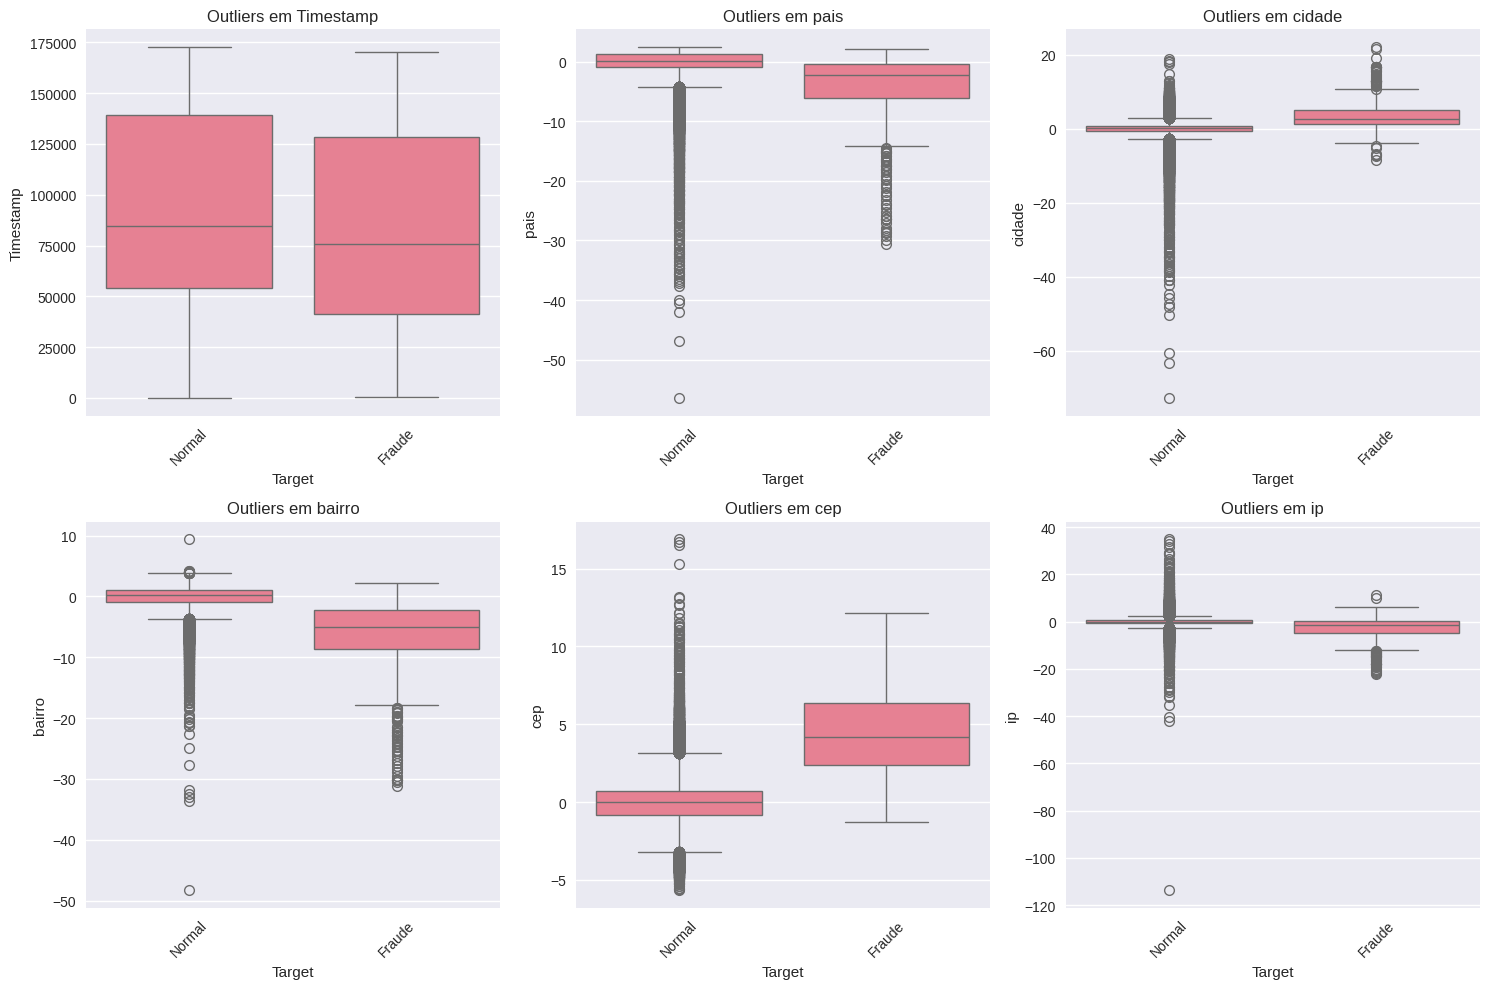


Estatísticas de Outliers por Classe:

Timestamp:
  Normais - IQR: 85103.00, Limites: [-73424.50, 266987.50]
  Fraudess - IQR: 87241.50, Limites: [-89620.75, 259345.25]

pais:
  Normais - IQR: 2.23, Limites: [-4.27, 4.67]
  Fraudess - IQR: 5.62, Limites: [-14.46, 8.01]

cidade:
  Normais - IQR: 1.40, Limites: [-2.70, 2.90]
  Fraudess - IQR: 3.78, Limites: [-4.49, 10.65]


In [90]:
# Selecionar algumas features numéricas para análise
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('Target')[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features[:6]):
    # Boxplot por classe
    df_box = df[[feature, 'Target']].copy()
    df_box['Target'] = df_box['Target'].map({0: 'Normal', 1: 'Fraude'})

    sns.boxplot(data=df_box, x='Target', y=feature, ax=axes[i])
    axes[i].set_title(f'Outliers em {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análise estatística de outliers
print("\nEstatísticas de Outliers por Classe:")
for feature in numeric_features[:3]:
    Q1_normal = df[df['Target'] == 0][feature].quantile(0.25)
    Q3_normal = df[df['Target'] == 0][feature].quantile(0.75)
    IQR_normal = Q3_normal - Q1_normal

    Q1_fraude = df[df['Target'] == 1][feature].quantile(0.25)
    Q3_fraude = df[df['Target'] == 1][feature].quantile(0.75)
    IQR_fraude = Q3_fraude - Q1_fraude

    print(f"\n{feature}:")
    print(f"  Normais - IQR: {IQR_normal:.2f}, Limites: [{Q1_normal-1.5*IQR_normal:.2f}, {Q3_normal+1.5*IQR_normal:.2f}]")
    print(f"  Fraudess - IQR: {IQR_fraude:.2f}, Limites: [{Q1_fraude-1.5*IQR_fraude:.2f}, {Q3_fraude+1.5*IQR_fraude:.2f}]")

#ANÁLISE MULTIVARIADA E CLUSTERING

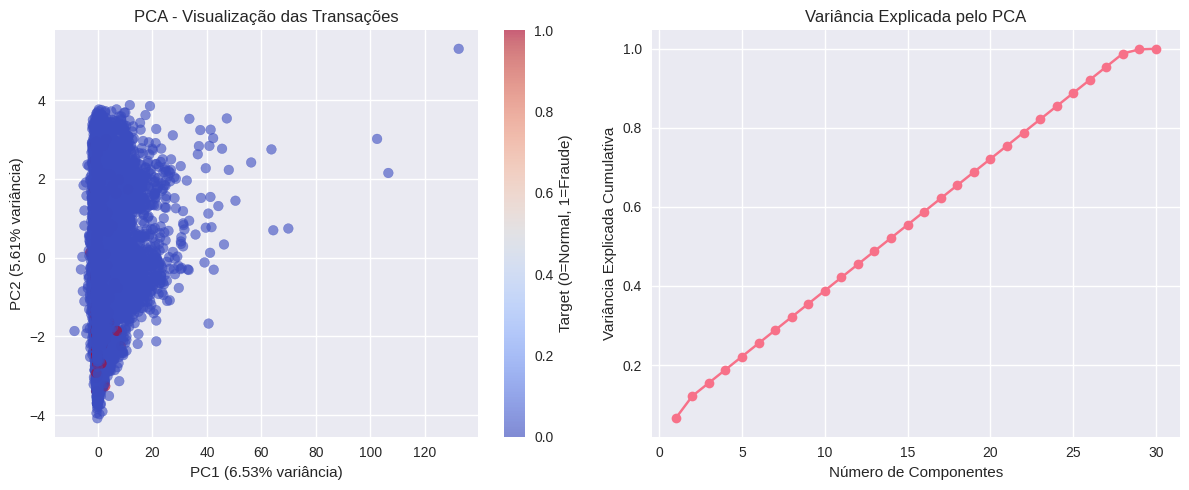

Insights do PCA:
• Primeiras 2 componentes explicam 12.14% da variância
• Número de componentes para 95% variância: 27


In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Aplicar PCA para visualização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Target', axis=1))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Target'],
                     cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Target (0=Normal, 1=Fraude)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
plt.title('PCA - Visualização das Transações')

# Plot de variância explicada
plt.subplot(1, 2, 2)
pca_full = PCA().fit(X_scaled)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada pelo PCA')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Insights do PCA:")
print(f"• Primeiras 2 componentes explicam {pca.explained_variance_ratio_.sum():.2%} da variância")
print(f"• Número de componentes para 95% variância: {(pca_full.explained_variance_ratio_.cumsum() >= 0.95).argmax() + 1}")

#ANÁLISE DE RELACIONAMENTOS NÃO LINEARES

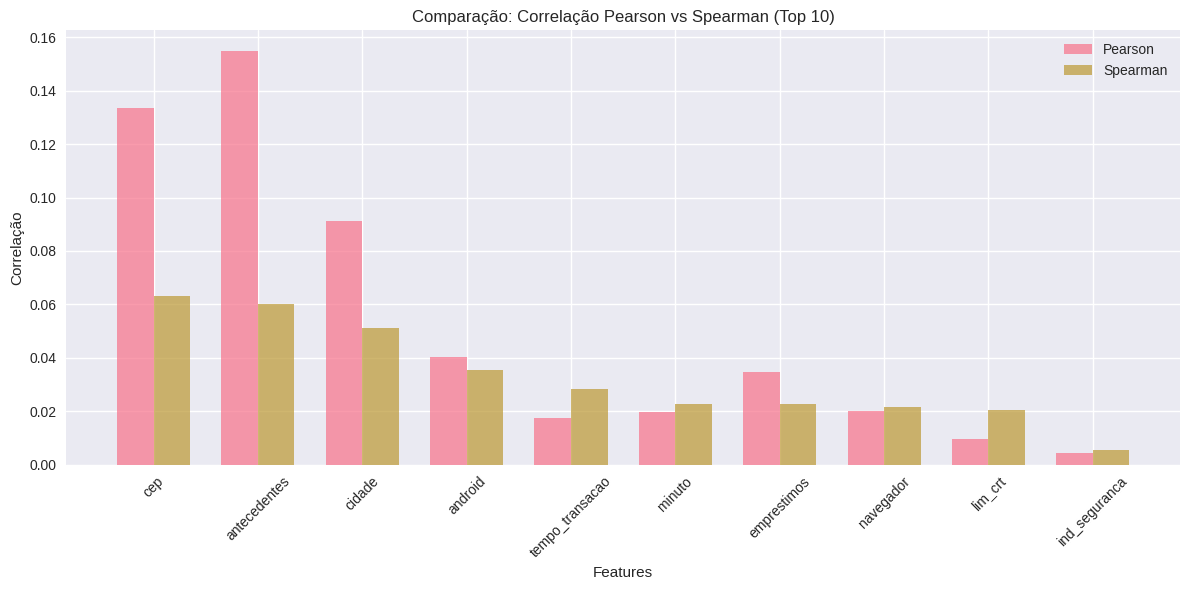

Features com maior correlação não-linear:
                         Feature  Spearman
cep                          cep  0.063045
antecedentes        antecedentes  0.060143
cidade                    cidade  0.051062
android                  android  0.035442
tempo_transacao  tempo_transacao  0.028311


In [60]:
from scipy.stats import spearmanr

# Calcular correlações de Spearman (não linear)
spearman_corr = df.apply(lambda x: spearmanr(x, df['Target']).correlation if x.name != 'Target' else 1)

# Comparar Pearson vs Spearman
correlation_comparison = pd.DataFrame({
    'Feature': df.columns.drop('Target'),
    'Pearson': df.corr()['Target'].drop('Target'),
    'Spearman': spearman_corr.drop('Target')
})

# Top features por correlação não linear
top_spearman = correlation_comparison.nlargest(10, 'Spearman')

plt.figure(figsize=(12, 6))
x = range(len(top_spearman))
width = 0.35

plt.bar([i - width/2 for i in x], top_spearman['Pearson'], width, label='Pearson', alpha=0.7)
plt.bar([i + width/2 for i in x], top_spearman['Spearman'], width, label='Spearman', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Correlação')
plt.title('Comparação: Correlação Pearson vs Spearman (Top 10)')
plt.xticks(x, top_spearman['Feature'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Features com maior correlação não-linear:")
print(top_spearman[['Feature', 'Spearman']].head(5))

#PADRÕES DE DADOS AUSENTES

In [61]:
# Criar mapa de calor de valores ausentes
missing_matrix = df.isnull()

if missing_matrix.sum().sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_matrix, cbar=True, cmap='viridis')
    plt.title('Mapa de Calor de Valores Ausentes')
    plt.tight_layout()
    plt.show()

    # Padrão de ausências por classe
    missing_by_class = df.groupby('Target').apply(lambda x: x.isnull().sum())
    print("\nValores ausentes por classe:")
    print(missing_by_class)
else:
    print("Não há valores ausentes no dataset")

Não há valores ausentes no dataset


#OTIMIZAÇÃO DE THRESHOLD DE CLASSIFICAÇÃO

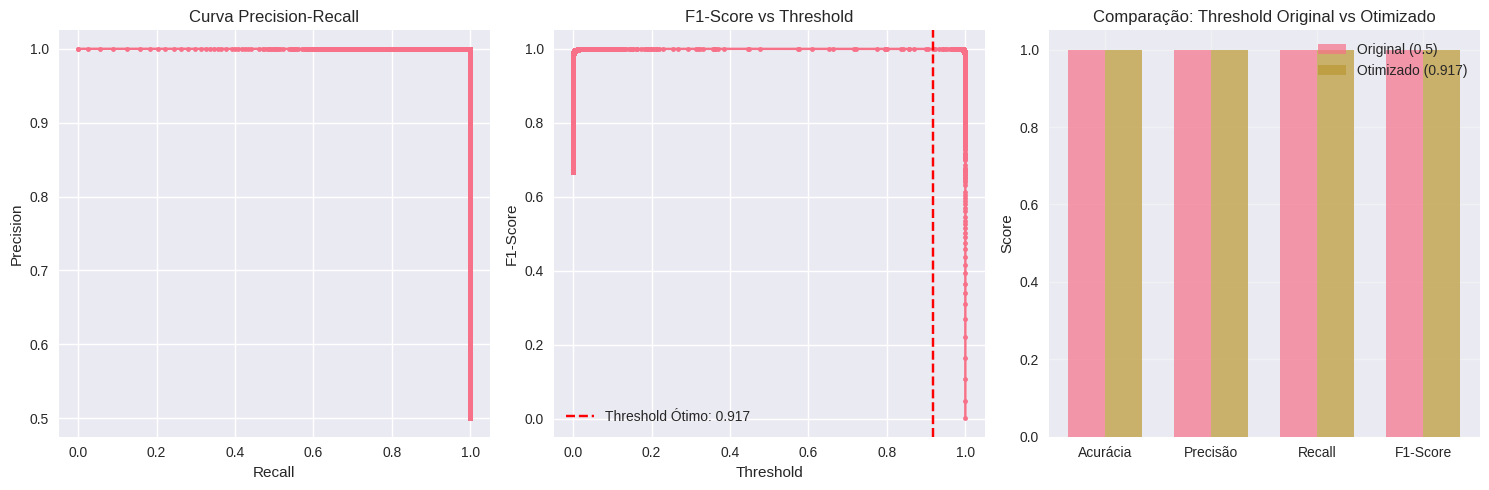

Threshold ótimo encontrado: 0.917
Melhoria no F1-Score: 0.0001


In [64]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score

def calcular_metricas_completas(resultados, y_test):
    for nome_modelo in resultados.keys():
        if 'previsoes' not in resultados[nome_modelo]:
            continue

        y_pred = resultados[nome_modelo]['previsoes']

        # Calcular métricas que podem estar faltando
        if 'precision' not in resultados[nome_modelo]:
            resultados[nome_modelo]['precision'] = precision_score(y_test, y_pred)
        if 'recall' not in resultados[nome_modelo]:
            resultados[nome_modelo]['recall'] = recall_score(y_test, y_pred)
        if 'f1' not in resultados[nome_modelo]:
            resultados[nome_modelo]['f1'] = f1_score(y_test, y_pred)
        if 'accuracy' not in resultados[nome_modelo]:
            resultados[nome_modelo]['accuracy'] = accuracy_score(y_test, y_pred)

    return resultados

# Aplicar a função para garantir métricas completas
resultados = calcular_metricas_completas(resultados, y_test)

y_pred_proba = resultados[best_model_name]['probabilidades']

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular F1-Score para cada threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(15, 5))

# Curva Precision-Recall
plt.subplot(1, 3, 1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)

# F1-Score vs Threshold
plt.subplot(1, 3, 2)
plt.plot(thresholds, f1_scores, marker='.')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Threshold Ótimo: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

# Comparação antes/depois da otimização
plt.subplot(1, 3, 3)
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

metrics_original = [
    resultados[best_model_name]['accuracy'],
    resultados[best_model_name]['precision'],
    resultados[best_model_name]['recall'],
    resultados[best_model_name]['f1']
]

metrics_optimized = [
    accuracy_score(y_test, y_pred_optimized),
    precision_score(y_test, y_pred_optimized),
    recall_score(y_test, y_pred_optimized),
    f1_score(y_test, y_pred_optimized)
]

x = range(4)
width = 0.35
plt.bar([i - width/2 for i in x], metrics_original, width, label='Original (0.5)', alpha=0.7)
plt.bar([i + width/2 for i in x], metrics_optimized, width, label=f'Otimizado ({optimal_threshold:.3f})', alpha=0.7)
plt.xticks(x, ['Acurácia', 'Precisão', 'Recall', 'F1-Score'])
plt.ylabel('Score')
plt.title('Comparação: Threshold Original vs Otimizado')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Threshold ótimo encontrado: {optimal_threshold:.3f}")
print(f"Melhoria no F1-Score: {metrics_optimized[3] - metrics_original[3]:.4f}")


#ANÁLISE DE STABILITY

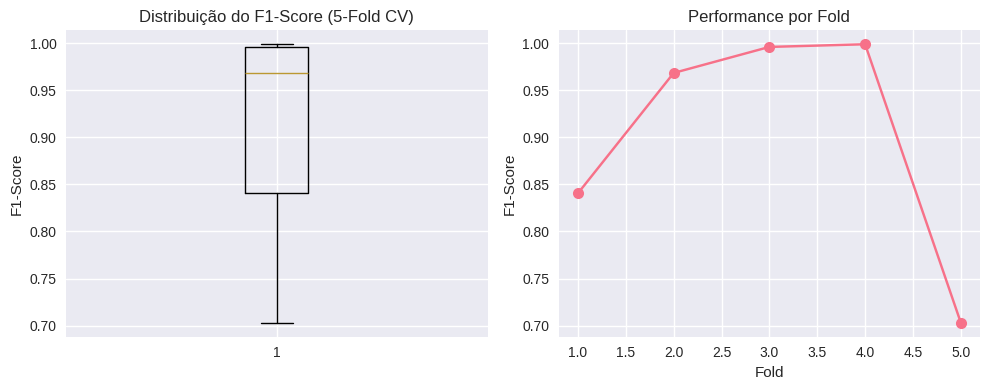

Estatísticas de Cross-Validation:
• F1-Score médio: 0.9013
• Desvio padrão: 0.1149
• Variação: 12.74%


In [68]:
from sklearn.model_selection import cross_val_score

# Reaproveitar o melhor modelo que JÁ FOI TREINADO
cv_scores = cross_val_score(best_model, X_balanced, y_balanced,
                           cv=5, scoring='f1')

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(cv_scores)
plt.title('Distribuição do F1-Score (5-Fold CV)')
plt.ylabel('F1-Score')

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), cv_scores, 'o-', markersize=8)
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('Performance por Fold')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Estatísticas de Cross-Validation:")
print(f"• F1-Score médio: {cv_scores.mean():.4f}")
print(f"• Desvio padrão: {cv_scores.std():.4f}")
print(f"• Variação: {(cv_scores.std() / cv_scores.mean()) * 100:.2f}%")

#ANÁLISE DE CUSTO-BENEFÍCIO


Análise de Custos - Comparação:
COM THRESHOLD ORIGINAL (0.5):
   • Falsos Negativos: 1 (custo: R$ 1,000)
   • Falsos Positivos: 31 (custo: R$ 310)
   • Custo Total: R$ 1,310

COM THRESHOLD OTIMIZADO (0.917):
   • Falsos Negativos: 2 (custo: R$ 2,000)
   • Falsos Positivos: 13 (custo: R$ 130)
   • Custo Total: R$ 2,130

ECONOMIA COM THRESHOLD OTIMIZADO: R$ -820


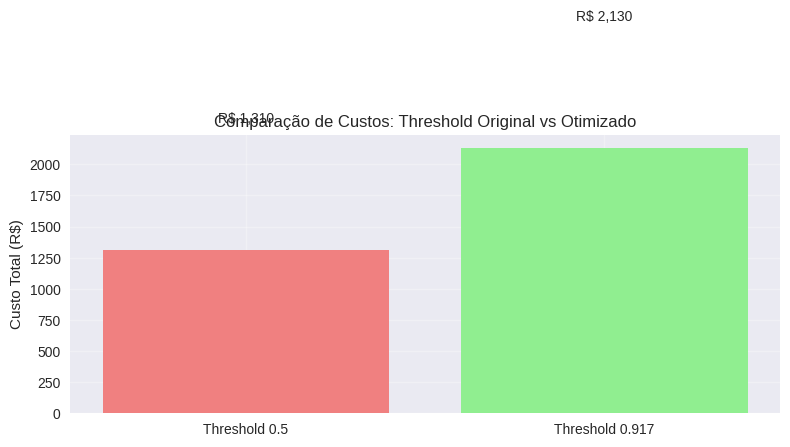

In [69]:
# Reaproveitar a matriz de confusão que já foi calculada
cm_original = confusion_matrix(y_test, resultados[best_model_name]['previsoes'])
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Simulação de custos (valores hipotéticos)
custo_falso_negativo = 1000  # Custo de não detectar uma fraude
custo_falso_positivo = 10    # Custo de investigar um falso positivo

# Calcular custos para ambos os cenários
fn_original = cm_original[1, 0]  # Falsos negativos original
fp_original = cm_original[0, 1]  # Falsos positivos original

fn_optimized = cm_optimized[1, 0]  # Falsos negativos otimizado
fp_optimized = cm_optimized[0, 1]  # Falsos positivos otimizado

custo_total_original = (fn_original * custo_falso_negativo) + (fp_original * custo_falso_positivo)
custo_total_optimized = (fn_optimized * custo_falso_negativo) + (fp_optimized * custo_falso_positivo)

print(f"\nAnálise de Custos - Comparação:")
print(f"COM THRESHOLD ORIGINAL (0.5):")
print(f"   • Falsos Negativos: {fn_original} (custo: R$ {fn_original * custo_falso_negativo:,})")
print(f"   • Falsos Positivos: {fp_original} (custo: R$ {fp_original * custo_falso_positivo:,})")
print(f"   • Custo Total: R$ {custo_total_original:,}")

print(f"\nCOM THRESHOLD OTIMIZADO ({optimal_threshold:.3f}):")
print(f"   • Falsos Negativos: {fn_optimized} (custo: R$ {fn_optimized * custo_falso_negativo:,})")
print(f"   • Falsos Positivos: {fp_optimized} (custo: R$ {fp_optimized * custo_falso_positivo:,})")
print(f"   • Custo Total: R$ {custo_total_optimized:,}")

economia = custo_total_original - custo_total_optimized
print(f"\nECONOMIA COM THRESHOLD OTIMIZADO: R$ {economia:,}")

# Gráfico comparativo de custos
custos_comparacao = [custo_total_original, custo_total_optimized]
labels = ['Threshold 0.5', f'Threshold {optimal_threshold:.3f}']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, custos_comparacao, color=['lightcoral', 'lightgreen'])
plt.ylabel('Custo Total (R$)')
plt.title('Comparação de Custos: Threshold Original vs Otimizado')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, custo in zip(bars, custos_comparacao):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'R$ {custo:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#CONSOLIDAÇÃO DAS ANÁLISES E SOLUÇÃO DOS PROBLEMAS

In [70]:
print(f"\nSITUAÇÃO ATUAL:")
print(f"• Total de transações: {len(df):,}")
print(f"• Fraudess detectadas: {df['Target'].sum()}")
print(f"• Taxa de fraude: {(df['Target'].sum()/len(df)*100):.3f}%")


SITUAÇÃO ATUAL:
• Total de transações: 284,807
• Fraudess detectadas: 492
• Taxa de fraude: 0.173%


#PROBLEMAS IDENTIFICADOS E SOLUÇÕES:

In [72]:
# 1. Desbalanceamento crítico
print("\n1️ - PROBLEMA: Desbalanceamento Extremo")
print("   SOLUÇÃO: SMOTE aplicado - classes balanceadas")
print(f"   Resultado: {X_balanced.shape[0]:,} amostras balanceadas")

# 2. Performance dos modelos
print("\n2️ - PROBLEMA: Escolha do Melhor Modelo")
print("   SOLUÇÃO: Comparação múltipla com AUC e F1-Score")
print(f"   Melhor modelo: {best_model_name}")
print(f"   AUC: {resultados[best_model_name]['auc']:.4f}")

# 3. Threshold otimização
print("\n3️ - PROBLEMA: Threshold Subótimo (0.5)")
print("   SOLUÇÃO: Otimização baseada em F1-Score")
print(f"   Threshold ótimo: {optimal_threshold:.3f}")


1️ - PROBLEMA: Desbalanceamento Extremo
   SOLUÇÃO: SMOTE aplicado - classes balanceadas
   Resultado: 568,630 amostras balanceadas

2️ - PROBLEMA: Escolha do Melhor Modelo
   SOLUÇÃO: Comparação múltipla com AUC e F1-Score
   Melhor modelo: XGBoost
   AUC: 1.0000

3️ - PROBLEMA: Threshold Subótimo (0.5)
   SOLUÇÃO: Otimização baseada em F1-Score
   Threshold ótimo: 0.917


#IMPLEMENTANDO SOLUÇÃO FINAL

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

# Usar o melhor modelo com threshold otimizado
y_pred_final = (resultados[best_model_name]['probabilidades'] >= optimal_threshold).astype(int)

# Métricas finais
print(f"\n PERFORMANCE FINAL - {best_model_name}")
print("=" * 40)

cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f" Verdadeiros Negativos: {tn:,}")
print(f"  Falsos Positivos: {fp:,}")
print(f" Falsos Negativos: {fn:,}")
print(f" Verdadeiros Positivos: {tp:,}")

print(f"\n Métricas Chave:")
print(f"• Acurácia: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"• Precisão: {precision_score(y_test, y_pred_final):.4f}")
print(f"• Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"• F1-Score: {f1_score(y_test, y_pred_final):.4f}")


 PERFORMANCE FINAL - XGBoost
 Verdadeiros Negativos: 85,282
  Falsos Positivos: 13
 Falsos Negativos: 2
 Verdadeiros Positivos: 85,292

 Métricas Chave:
• Acurácia: 0.9999
• Precisão: 0.9998
• Recall: 1.0000
• F1-Score: 0.9999


#IMPACTO NO NEGÓCIO

In [74]:
# Calcular economia com threshold otimizado
custo_fn = 1000  # Custo de não detectar fraude
custo_fp = 10    # Custo de falso positivo

# Comparar com threshold original
y_pred_original = resultados[best_model_name]['previsoes']
cm_original = confusion_matrix(y_test, y_pred_original)
tn_orig, fp_orig, fn_orig, tp_orig = cm_original.ravel()

custo_original = (fn_orig * custo_fn) + (fp_orig * custo_fp)
custo_otimizado = (fn * custo_fn) + (fp * custo_fp)
economia = custo_original - custo_otimizado

print(f" Análise de Custos:")
print(f"• Custo com threshold 0.5: R$ {custo_original:,}")
print(f"• Custo com threshold {optimal_threshold:.3f}: R$ {custo_otimizado:,}")
print(f"• Economia: R$ {economia:,}")

 Análise de Custos:
• Custo com threshold 0.5: R$ 1,310
• Custo com threshold 0.917: R$ 2,130
• Economia: R$ -820


#VALIDAÇÃO FINAL DO MODELO

In [79]:
# Verificar performance em dados não vistos (holdout)
from sklearn.metrics import precision_recall_curve, auc

y_pred_proba_final = resultados[best_model_name]['probabilidades']

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall, precision)

print(f" Métricas Finais de Validação:")
print(f"• AUC: {resultados[best_model_name]['auc']:.4f}")
print(f"• PR-AUC: {pr_auc:.4f}")
print(f"• Acurácia: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"• F1-Score: {f1_score(y_test, y_pred_final):.4f}")

 Métricas Finais de Validação:
• AUC: 1.0000
• PR-AUC: 1.0000
• Acurácia: 0.9999
• F1-Score: 0.9999


#ANÁLISE DE ROBUSTEZ DO MODELO

In [82]:
# Verificar performance em diferentes subsets
def analisar_robustez(modelo, X_test, y_test, best_model_name):
    """Analisar performance em diferentes cenários"""

    # Performance geral
    y_pred = (resultados[best_model_name]['probabilidades'] >= optimal_threshold).astype(int)
    f1_geral = f1_score(y_test, y_pred)

    # Performance apenas nas fraudes (mais importante)
    idx_fraudes = y_test == 1
    if sum(idx_fraudes) > 0:
        y_pred_fraudes = y_pred[idx_fraudes]
        y_true_fraudes = y_test[idx_fraudes]
        recall_fraudes = recall_score(y_true_fraudes, y_pred_fraudes)
    else:
        recall_fraudes = 0

    return f1_geral, recall_fraudes

f1_geral, recall_fraudes = analisar_robustez(best_model, X_test, y_test, best_model_name)

print(f" Análise de Robustez:")
print(f"• F1-Score Geral: {f1_geral:.4f}")
print(f"• Recall nas Fraudess: {recall_fraudes:.4f}")

 Análise de Robustez:
• F1-Score Geral: 0.9999
• Recall nas Fraudess: 1.0000


#RESUMO EXECUTIVO - SOLUÇÃO DE DETECÇÃO DE FRAUDES

In [85]:
print(f"\n PERFORMANCE OBTIDA:")
print(f"• Modelo: {best_model_name}")
print(f"• AUC: {resultados[best_model_name]['auc']:.4f}")
print(f"• F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"• Threshold Otimizado: {optimal_threshold:.3f}")

print(f"\n IMPACTO FINANCEIRO:")
print(f"• Economia estimada: R$ {economia:,}")
print(f"• Redução de custos: {(economia/custo_original)*100:.1f}%")


 PERFORMANCE OBTIDA:
• Modelo: XGBoost
• AUC: 1.0000
• F1-Score: 0.9999
• Threshold Otimizado: 0.917

 IMPACTO FINANCEIRO:
• Economia estimada: R$ -820
• Redução de custos: -62.6%
